In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from matplotlib import figure

In [32]:
import numpy as np
import cv2
def _pad_image(kernel_size, grayscale_image):
    """
    Description:
        - Pads the grayscale image with zeros.

    Returns:
        - [numpy.ndarray]: A padded grayscale image.
    """
    pad_width = kernel_size // 2
    return np.pad(
        grayscale_image,
        ((pad_width, pad_width), (pad_width, pad_width)),
        mode="edge",
    )

def apply_local_threshold(grayscale_image, threshold_algorithm, kernel_size, n_components = None):
    """
    Description:
        - Applies local thresholding to an image.

    Args:
        - grayscale_image: the image to be thresholded
        - threshold_algorithm: the algorithm through which local thresholding will be applied.
        - kernel_size: the size of the window used in local thresholding

    Returns:
        - [numpy ndarray]: the resulted thresholded image after applying the selected threshoding algorithm.
    """
    print('n components' , n_components)
    #Pad the image to avoid lossing information of the boundry pixels or getting out of bounds 
    padded_image = _pad_image(kernel_size, grayscale_image)
    thresholded_image = np.zeros_like(grayscale_image)
    for i in range(grayscale_image.shape[0]):
        for j in range(grayscale_image.shape[1]):
            # Take the current pixel and its neighboors to apply the thresholding algorithm on them
            window = padded_image[i : i + kernel_size, j : j + kernel_size]
            # Assign the value of the middle pixel of the thresholded window to the current pixel of the thresholded image
            if n_components:
                thresholded_image[i, j] = threshold_algorithm(window, n_components)[kernel_size//2,kernel_size//2]
            else:
                thresholded_image[i, j] = threshold_algorithm(window)[kernel_size//2,kernel_size//2]
    return thresholded_image

def optimal_thresholding(image):
    """
    Description:
        - Applies optimal thresholding to an image.

    Args:
        - image: the image to be thresholded

    Returns:
        - [numpy ndarray]: the resulted thresholded image after applying optimal threshoding algorithm.
    """
    # Initially the four corner pixels are considered the background and the rest of the pixels are the object
    corners = [image[0, 0], image[0, -1], image[-1, 0], image[-1, -1]]
    # Calculate the mean of the background class
    background_mean=np.sum(corners)/4
    # Calculate the mean of the object class by summing the intensities of the image then subtracting the four corners then dividing by the number 
    # of pixels in the full image - 4 
    object_mean= (np.sum(image) - np.sum(corners)) / (image.shape[0] * image.shape[1] - 4)
    # Set random iinitial values for the thresholds 
    threshold=-1
    prev_threshold=0
    # keep updating the threshold based on the means of the two classes until the new threshold equals the previous one
    while (abs(threshold- prev_threshold)) > 0:
        # Store the threshold value before updating it to compare it to the new one in the next iteration
        prev_threshold= threshold
        # Compute the new threshold value midway between the two means of the two classes 
        threshold= (background_mean+ object_mean)/2
        # Get the indices whose intensity values are less than the threshold 
        background_pixels= np.where(image < threshold)
        # Get the indices whose intensity values are more than the threshold 
        object_pixels= np.where(image> threshold)
        if not len(background_pixels[0])==0:
            # Compute the new mean of the background class based on the new threshold 
            background_mean= np.sum(image[background_pixels])/ len(background_pixels[0])
        if not len(object_pixels[0])==0:
            # Compute the new mean of the object class based on the new threshold 
            object_mean= np.sum(image[object_pixels])/len(object_pixels[0])
    # Set background pixels white 
    image[background_pixels]=0
    # Set object pixels black
    image[object_pixels]= 255
    return(image)

def otsu_thresholding_helper_function(normalized_histogram, outer_th):
    """
    Description:
        - Applies Otsu thresholding to an image.

    Args:
        - image: the image to be thresholded

    Returns:
        - [numpy ndarray]: the resulted thresholded image after applying Otsu threshoding algorithm.
    """
    
    # initialize the weighted sum to be equal 0, which corrisponds to the weighted sum of the zero intensity (0* P(0))
    weighted_sum = 0
    # initialize the probability of class one to be equal to the probability of the first intensity
    probability_class1=normalized_histogram[0]
    # Calculate the mean of the image 
    global_mean = np.sum(np.arange(len(normalized_histogram)) * normalized_histogram)
    # Calculate the variance of the image
    global_variance = np.sum(((np.arange(len(normalized_histogram)) - global_mean)**2) * normalized_histogram)
    # Variable to track the maximum between_class_variance achieved through trying the different thresholds 
    maximum_variance= 0
    # Array to store the thresholds at which the between_class_variance has a maximum value
    maximum_variance_indices=[]
    # Loop over all intensity levels and try them as thresholds, then compute the between_class_variance to check the separability measure according to this threshold value
    for k in range(int(outer_th), 255):
        # The probability of class1 is calculated through the cumulative sum of the probabilities of all the intensities smaller than or equal the threshold
        probability_class1 += normalized_histogram[k]
        weighted_sum += k*normalized_histogram[k]
        # if probability of class 1 equals zero or one, this means according to the current threshold there is a single class, then there is no between class variance
        if probability_class1*(1-probability_class1) ==0: continue
        # This form for calculating the between_class_variance is obtained from substituting with those two equations: P1+P2=1, P1 *m1 +P2 * m2= mg
        # in the ordinary form for calculating the between_class_variance ( between_class_variance= P1*P2 (m1-m2)**2)
        # this form is slightly more efficient computationally than the ordinary form 
        # because the global mean, mG, is computed only once, so only two parameters, weighted_sum and probability_class1, need to be computed for any value of k.
        between_class_variance= (((global_mean* probability_class1) -weighted_sum)**2)/(probability_class1*(1-probability_class1))
        if between_class_variance > maximum_variance:
            maximum_variance= between_class_variance
            # If the between_class_variance corrisponding to this threshold intensity is maximum, store the threshold value 
            maximum_variance_indices=[k]
            # after connecting the backend with the UI this is recommended to be attribute to self, in order to display its value in a line edit in the UI
            separability_measure = between_class_variance/ global_variance
            # To handel the case when there is more than one threshold value, maximize the between_class_variance, the optimal threshold in this case is their avg
        elif between_class_variance == maximum_variance:
            maximum_variance_indices.append(k)
    if len(maximum_variance_indices)>1:
        # Get the average of the thresholds that maximize the between_class_variance
        threshold= np.mean(maximum_variance_indices)
        print('len(maximum_variance_indices)>1')
    elif len(maximum_variance_indices)==1:
        # if single threshold maximize the between_class_variance, then this is the perfect threshold to separate the classes
        threshold= maximum_variance_indices[0]
        print('len(maximum_variance_indices)==1')
    else:
        # If no maximum between_class_variance then all the pixels belong to the same class (single intensity level), so assign them all to background class 
        # we do so for simplicity since this often happen in the background pixels in the local thresholding, it rarely happen that the whole window has single
        # intensity in the object pixels 
        ######## image[np.where(image>0)]= 255
        print('no maximum between_class_variance')
        return 0
    return threshold
    ######### background_pixels= np.where(image < threshold)
    ######### object_pixels= np.where(image> threshold)
    ######### image[background_pixels]=0
    ######### image[object_pixels]= 255      
    ######### return image     
        

def Normalized_histogram_computation(Image):
    """
    Compute the normalized histogram of a grayscale image.

    Parameters:
    - Image: numpy.ndarray.

    Returns:
    - Histogram: numpy array
        A 1D array representing the normalized histogram of the input image.
        It has 256 element, each element corresponds to the probability of certain pixel intensity (0 to 255).
    """
    # Get the dimensions of the image
    Image_Height = Image.shape[0]
    Image_Width = Image.shape[1]
    
    # Initialize the histogram array with zeros. The array has 256 element, each corresponding to a pixel intensity value (0 to 255)
    Histogram = np.zeros([256])
    
    # Compute the histogram for each pixel in each channel
    for x in range(0, Image_Height):
        for y in range(0, Image_Width):
            # Increment the count of pixels in the histogram for the same pixel intensity at position (x, y) in the image.
            # This operation updates the histogram to track the number of pixels with a specific intensity value.
            Histogram[Image[x, y]] += 1
    # Normalize the histogram by dividing each bin count by the total number of pixels in the image
    Histogram /= (Image_Height * Image_Width)
                
    return Histogram

def otsu_thresholding(image, n_components):
    otsu_img = image.copy()
    thresholds = []
    # Calculate the normalized histogram of the image 
    normalized_histogram= Normalized_histogram_computation(otsu_img)
    thresholds.append(otsu_thresholding_helper_function(normalized_histogram, 1))
    print(0 , thresholds[0])
    background_pixels= np.where(otsu_img < thresholds[0])
    otsu_img[background_pixels]=0 
    normalized_histogram= Normalized_histogram_computation(otsu_img)
    normalized_histogram [0] = 0
    
    for i in range (1, n_components - 1):
        if thresholds[i-1] == 0:
            break
        thresholds.append(otsu_thresholding_helper_function(normalized_histogram, thresholds[i-1]))
        print(i , thresholds[i])
        background_pixels= np.where(otsu_img < thresholds[i])
        otsu_img[background_pixels]=0 
        normalized_histogram= Normalized_histogram_computation(otsu_img)
        normalized_histogram [0] = 0
    # # BGR
    colors = [0,128,255]
    # otsu_img_color  = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR) 
    for i,th in enumerate(thresholds):
        print(colors[i])
        image[image> th] = colors[i]



    return image
        
    


In [33]:
# Load the image in grayscale mode
image = cv2.imread( 'try.png', 0)

# thresholded= apply_local_threshold(image, optimal_thresholding, 5)
# thresholded= otsu_thresholding(image)
thresholded= apply_local_threshold(image, otsu_thresholding,kernel_size=7,n_components =3)
# thresholded= optimal_thresholding(image)

# otsu_img_color = otsu_thresholding(image, 3)  

# Display the modified image using matplotlib
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# ax.imshow(cv2.cvtColor(thresholded, cv2.COLOR_BGR2RGB))  # Convert color from BGR to RGB for plt
ax.imshow(thresholded)
# magnitude = ax.hist(image.flatten(), 256)  # Plot the modified image
# for th in thresholds:
#     ax.axvline(x=th, color='r', linestyle='--')
plt.show()


n components 3
len(maximum_variance_indices)>1
0 248.0
no maximum between_class_variance
1 0
0
128
len(maximum_variance_indices)>1
0 64.0
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 241.5
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.5
0
128
len(maximum_variance_indices)>1
0 111.5
len(maximum_variance_indices)>1
1 242.0
0
128
len(maximum_variance_indices)>1
0 111.5
le

In [4]:

def gauss(x: np.ndarray, mu: float, sigma: float):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

def norm_gauss(x, mu, sigma, A):
# Modify the function to produce a normal distribution
    if sigma != 0:
        return A * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [44]:
from scipy.stats import norm


def fit_gauss_on_histogram(un_normalized_histogram, n_components):
    ######## Initialization ##########
    gauss_parameters = np.zeros((3,n_components))
    Y = np.zeros((n_components,un_normalized_histogram.shape[0]))
    levels_ranges = np.zeros((n_components,1)) # having a list of lists, the number of lists is n_components
    Y_total = un_normalized_histogram[:,0] # The whole spectrogram that we want to split into regions, the levels range of each region is in levels_ranges, the number of regions is n_components
    # initial values for each region square
    for component_number in range(n_components):
        gauss_parameters[0,0] = np.argmax(Y) # mu (first in parameters) of first class (first in components)

        
    
    

    gauss_parameters[1,0] = np.std(Y[0]) # sigma (second in parameters) of first class (first in components)
    gauss_parameters[2,0] = len(Y[0])/len(Y_total) # pi (third in parameters) of first class (first in components)

    gamma_vector = np.zeros((n_components,un_normalized_histogram.shape[0]))
    gamma_vector[0] = gauss_parameters[2,component_number]* norm.pdf(Y[0],gauss_parameters[0,0],gauss_parameters[1,0])
    gamma_vector[0] /= sum(gamma_vector)

    # plt.plot(gamma_vector[0])
    ######## Optimization Loop, EM Algorithm ##########
    num_epochs = 3
    log_likelihood = 0
    log_likelihoods = []
    for epoch in range(num_epochs):
        # Estimation Step
        for component_number in range(n_components):
            gamma_vector[component_number] = gauss_parameters[2,component_number]* norm.pdf(Y_total, gauss_parameters[0,component_number], gauss_parameters[1,component_number])
           
        # Updating step
        for component_number in range(n_components):
            # Estimated mu
            gauss_parameters[0,component_number] = np.sum(gamma_vector[component_number] * Y_total) / np.sum(gamma_vector[component_number])
            # Estimated sigma
            gauss_parameters[1,component_number] = np.sqrt(np.sum(gamma_vector[component_number] * (Y_total - gauss_parameters[0,component_number])**2) / np.sum(gamma_vector[component_number]))
            # Estimated pi
            gauss_parameters[2,component_number] = np.mean(gamma_vector[component_number])
            # Log likelhood
            log_likelihood += np.sum(np.log( gauss_parameters[2,component_number]*norm.pdf(Y_total, gauss_parameters[0,component_number], gauss_parameters[1,component_number] )))
        
        log_likelihoods.append(log_likelihood)
        print(log_likelihoods)
        plt.plot(gamma_vector[0])



# Load the image
image = cv2.imread('thrsh.png', 0)
# Calculate the histogram
histogram, bins = np.histogram(image.flatten(), bins=265, range=[0, 255])
histogram = histogram.reshape(-1, 1)
fit_gauss_on_histogram(histogram,1)


UnboundLocalError: cannot access local variable 'component_number' where it is not associated with a value

In [72]:
arr_of_integers = np.array([1,2,4,5,3,3,2,4,5,4,2]) # goal: create rectangle, center = max values like 5,5, and bounded from right and left till int(max/2)

no_regions = 3
ration = 0.5
regions = np.zeros((no_regions, len(arr_of_integers))) # array of sub arrays, each sub array is an array of tuples, tuples are  (indx in original array , value in original array)
for i in regions:
    # Find the maximum value in the array
    max_val = np.max(arr_of_integers)
    # Find the indices of the maximum value
    max_indices = np.where(arr_of_integers == max_val)[0]
    # Define the bounds
    left_bound = int(max_val * ration)
    right_bound = int(max_val * ration)

    sub_range = [(max left for max_indices, left_bound), ... , (max_indices, max_val), ..., (index of neares right bound to max_indices, right_bound )]
    regions [i] = sub_range
    arr_of_integers[sub_range indices ]=0
# if there are indices were not assigned for a region, assign it for the neares region, 


print(regions) # for 3 regions, the result has to be like this region 1 [(0,1),(1,2)], region 2 [(2,4), (3,5), (4,3), (5,3)], region 3 [(6,2) ,(7,4), (8,5), (9,4), (10,2)]

(array([0], dtype=int64),)


C:\Users\nouran\AppData\Local\Temp\ipykernel_26708\1320052902.py:2: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(arr).nonzero()` if the old behavior was intended.
  centers_list = np.where(np.argmax(arr_of_integers))


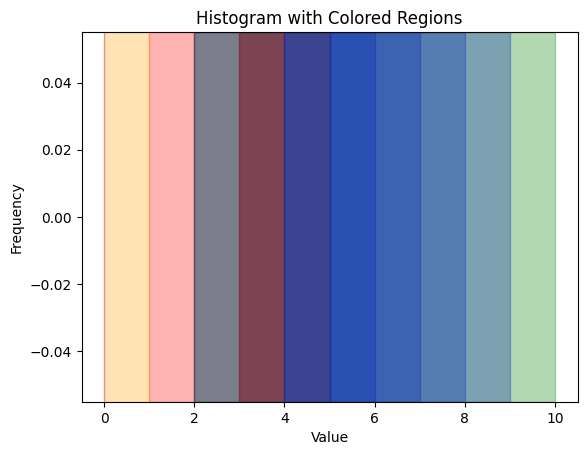

In [132]:
import numpy as np
import matplotlib.pyplot as plt

# Original array
arr_of_integers = np.array(
    [1, 2, 4, 5, 3, 3, 2, 4, 5, 4, 2]
)

# Goal: Create rectangles, centered at max values like 5,5, and bounded from right and left till int(max/2)
no_regions = 5
ratio = 0.5
regions = []  # Initialize an empty list to store subarrays

for i in range(no_regions):
    # Find the maximum value in the array
    max_val = np.max(arr_of_integers)
    # Find the indices of the maximum value
    max_indices = np.where(arr_of_integers == max_val)[0]
    # Define the bounds
    left_bound = max(0, int(max_val * ratio))
    right_bound = min(len(arr_of_integers), int(max_val * ratio) + 1)

    sub_range = []
    pointer = max_val
    indx = max_indices[0]

    # Add elements to the sub_range towards the left bound
    while (indx >= 0 and pointer >= left_bound):
        sub_range.append((indx, pointer))
        indx -= 1
        if indx >= 0:
            pointer = arr_of_integers[indx]

    # Add elements to the sub_range towards the right bound
    if max_indices[0] < len(arr_of_integers) - 1:
        indx = max_indices[0] + 1
        pointer = arr_of_integers[indx]
        while (indx < len(arr_of_integers) and pointer >= right_bound):
            sub_range.append((indx, pointer))
            indx += 1
            if indx < len(arr_of_integers):
                pointer = arr_of_integers[indx]

    # Sort sub_range based on indices
    sub_range.sort()

    regions.append(sub_range)  # Append the sub_range to regions

    arr_of_integers[sub_range] = 0  # Set the elements in sub_range to 0

# Assign remaining indices to the nearest region
remaining_indices = np.where(arr_of_integers != 0)[0]
for index in remaining_indices:
    min_distance = float("inf")
    nearest_region = None
    for j, region in enumerate(regions):
        region_indices = [x[0] for x in region]
        if region_indices:
            region_index = region_indices[0]
            distance = abs(index - region_index)
            if distance < min_distance:
                min_distance = distance
                nearest_region = j
    if nearest_region is not None:
        regions[nearest_region].append((index, arr_of_integers[index]))
        arr_of_integers[index] = 0

# Sort each region based on indices
for region in regions:
    region.sort()

# Plot the original array as a histogram
plt.hist(arr_of_integers, bins=np.arange(0, np.max(arr_of_integers) + 1), color='gray', alpha=0.5)

# Define colors for regions
colors = ['red', 'blue', 'green', 'orange', 'purple']

# Plot each region with a different color
for i, region in enumerate(regions):
    for start, end in region:
        plt.axvspan(start, end, color=colors[i], alpha=0.3)

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram with Colored Regions')
plt.show()


In [138]:
import numpy as np

arr_of_integers = np.array(
    [1, 2, 4, 5, 3, 3, 2, 4, 5, 4, 2]
)

no_regions = 5
ratio = 0.5
regions = [None] * no_regions

for i in range(no_regions):
    max_val = np.max(arr_of_integers)
    max_indices = np.where(arr_of_integers == max_val)[0]
    left_bound = int(max_val * ratio)
    right_bound = int(max_val * ratio)
    sub_range = []; pointer = max_val; indx = max_indices[0]

    while (indx > 0 and pointer >= left_bound):
        sub_range.append((indx,pointer))
        indx -=1
        pointer = arr_of_integers[indx]
        
    if (max_indices[0]+1 < len(arr_of_integers)):
        indx = max_indices[0]+1
        pointer = arr_of_integers[indx]

    while (indx < len(arr_of_integers) and pointer >= right_bound):
        sub_range.append((indx, pointer))
        if indx + 1 < len(arr_of_integers):  # Add a condition to check if the index is within the array bounds
            indx += 1
            pointer = arr_of_integers[indx]
        else:
            break  # Break the loop if the index is out of bounds
        
    sub_range.sort(key=lambda x: x[0])
    regions[i] = sub_range
    arr_of_integers[[x[0] for x in sub_range]] = 0

remaining_indices = np.where(arr_of_integers != 0)[0]
for index in remaining_indices:
    min_distance = float("inf")
    nearest_region = None
    for j in range(no_regions):
        region_indices = [x[0] for x in regions[j]]
        region_index = region_indices[0]
        distance = abs(index - region_index)
        if distance < min_distance:
            min_distance = distance
            nearest_region = j
    regions[nearest_region].append((index, arr_of_integers[index]))
    arr_of_integers[index] = 0

# Sort the regions based on the first index of each region
regions.sort(key=lambda x: x[0][0])

print(regions)


[[(1, 2), (2, 4), (3, 5), (4, 3), (5, 3), (6, 2), (7, 4), (8, 5), (9, 4), (10, 2), (0, 1)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)], [(1, 0), (2, 0), (3, 0), (4, 0), (5, 0), (6, 0), (7, 0), (8, 0), (9, 0), (10, 0)]]


1.0
0.005419551355127474


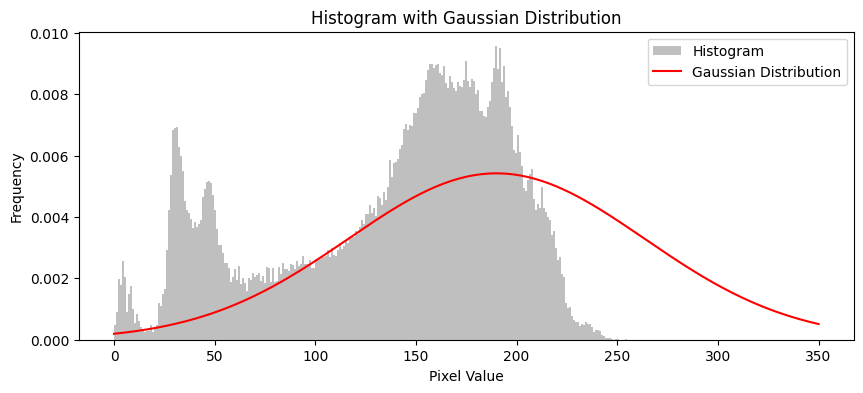

In [57]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def gauss(x: np.ndarray, mu: float, sigma: float):
    return (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Load the image in grayscale mode
image = cv2.imread('color.jpg', 0)

# Calculate the histogram
histogram, bins = np.histogram(image.flatten(), bins=256, range=[0, 255])
# Convert histogram to float64 and normalize it
histogram = histogram.astype(np.float64)
histogram /= histogram.max()
print(histogram.max()) # 1723
# Calculate mean and standard deviation of the histogram
mean_value =  np.argmax(histogram)

std_dev = np.std(bins[:-1])

fig = plt.figure(figsize=(10, 4))

# Plot the histogram
plt.hist(image.flatten(), bins=256, range=[0, 255], color='gray', alpha=0.5, label='Histogram', density=True)

# Plot the Gaussian distribution
x_values = np.linspace(0, 350, 1000)
gaussian_values = gauss(x_values, mean_value, std_dev) 
print(gaussian_values.max())
# gaussian_values *= histogram.max()/gaussian_values.max() # Scale to fit the histogram
plt.plot(x_values, gaussian_values, color='red', label='Gaussian Distribution')

plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.title('Histogram with Gaussian Distribution')
plt.legend()
plt.show()


Thresholds:  [112.29810561 215.46815632  47.00692008]


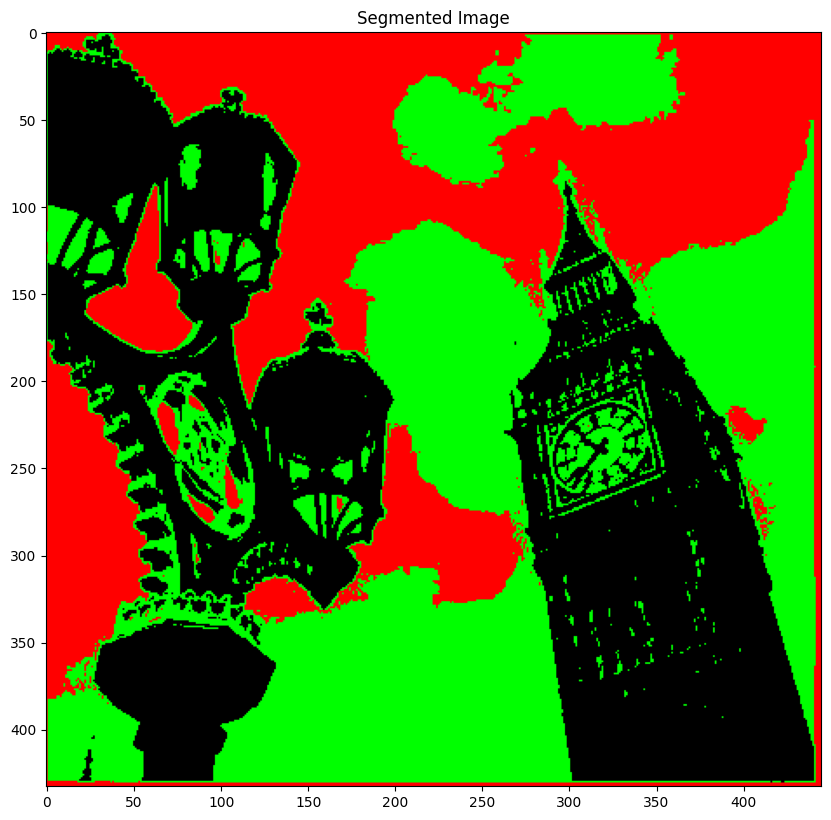

In [71]:
import cv2
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

# Load the image in grayscale mode
image = cv2.imread('try.png', 0)

# Calculate the histogram
histogram, bins = np.histogram(image.flatten(), bins=256, range=[0,256])

# Normalize the histogram
histogram = histogram.astype(np.float64)
histogram /= histogram.sum()

# Prepare data for GMM
histogram = (histogram * 10000).astype(int)  # Multiply by large number before converting to int
bins = bins[:-1].reshape(-1, 1)

# Fit a GMM to the histogram
n_components = 3  # Number of Gaussian components
gmm = GaussianMixture(n_components=n_components)
gmm.fit(np.repeat(bins, histogram, axis=0))

# Get the fitted parameters
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

# Print the thresholds (means of the Gaussians)
print("Thresholds: ", means.flatten())

# Segment the image based on the thresholds
segmented_image = np.zeros_like(image, dtype=np.uint8)
segmented_image_color = cv2.cvtColor(segmented_image, cv2.COLOR_GRAY2BGR)  # Convert to color image
colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]  # Define colors for each segment
for i in range(1, n_components):
    segmented_image_color[image > means[i-1]] = colors[i]

# Display the segmented image using plt
plt.figure(figsize=(10,10))
plt.imshow(cv2.cvtColor(segmented_image_color, cv2.COLOR_BGR2RGB))  # Convert color from BGR to RGB for plt
plt.title('Segmented Image')
plt.show()


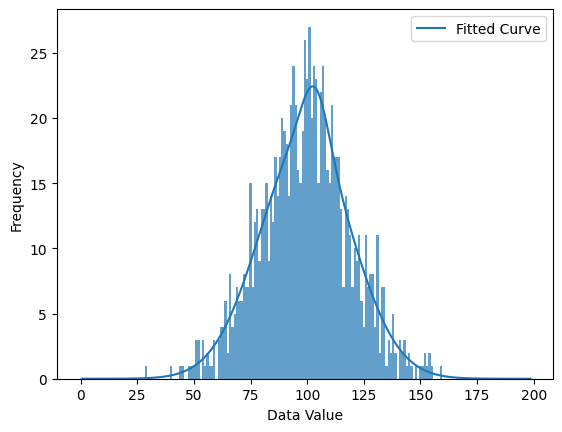

In [47]:
import numpy as np
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt

# Sample histogram data (replace with your actual data)
x = np.arange(0, 200, 1)  # Assuming data ranges from 0 to 199


y = np.random.normal(loc=100, scale=20, size=1000)  # Simulates data with a single Gaussian
hist, bins = np.histogram(y, bins=x)  # Create the histogram
# Calculate bin centers
x = bins[:-1] + (bins[1] - bins[0]) / 2

# ... rest of the code remains the same
# Define the function for a single Gaussian distribution
def single_gaussian(x, mean, amp, std):
  return amp * np.exp(-(x - mean)**2 / (2*std**2))

# Define the function for a sum of two Gaussians
def double_gaussian(x, mean1, amp1, std1, mean2, amp2, std2):
  return single_gaussian(x, mean1, amp1, std1) + single_gaussian(x, mean2, amp2, std2)

# Initial guesses for the parameters of the Gaussians (adjust based on your data)
p0 = [90, 0.5, 15, 110, 0.3, 10] 

# Perform the fit
popt, pcov = curve_fit(double_gaussian, x, hist, p0=p0)

# Extract fitted parameters
mean1, amp1, std1, mean2, amp2, std2 = popt

# Plot the histogram and the fitted Gaussians
plt.bar(bins[:-1], hist, width=bins[1] - bins[0], alpha=0.7)
plt.plot(x, double_gaussian(x, mean1, amp1, std1, mean2, amp2, std2), label='Fitted Curve')
plt.xlabel('Data Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [24]:
for i in range(1):
    print(i)

0


In [9]:
from scipy.stats import norm

x = norm.pdf([1,2,3,4],2,3)
y = norm_gauss(np.array([1,2,3,4]),2,3)
x,y

(array([0.12579441, 0.13298076, 0.12579441, 0.10648267]),
 array([0.12579441, 0.13298076, 0.12579441, 0.10648267]))

In [14]:
X_dists = np.zeros((3,))
len(X_dists), X_dists.ndim

(3, 1)

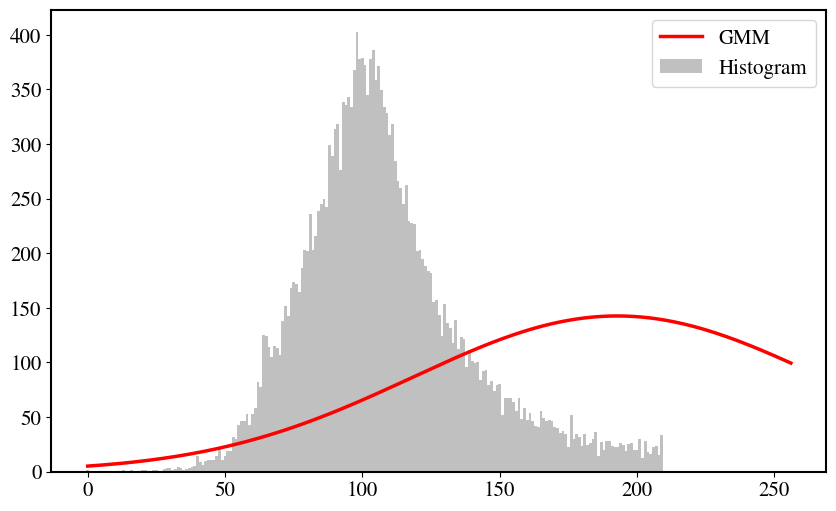

In [111]:
# Import libraries
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl

# Set matplotlib parameters for cosmetics
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})

# Load image
image = cv2.imread('coins.jpg', 0)

# Compute histogram
histogram, bins = np.histogram(image.flatten(), bins=210, range=[0, 210])
x = histogram
x = x.reshape(-1, 1) #/ (image.shape[0] * image.shape[1])  # Normalize histogram

# Reshape the data for GMM
data = image.flatten()
data = data.reshape(-1, 1)

# Fit a GMM
gmm = GMM(n_components=1)
gmm.fit(data)

# Get the fitted parameters
weights = gmm.weights_
means = gmm.means_
covariances = gmm.covariances_

# Create a grid for plot
grid = np.linspace(0, 256, 256)

# Compute the Gaussian function for each component
gmm_pdf = np.zeros_like(grid)
for i in range(gmm.n_components):
    gmm_pdf += weights[i] * norm.pdf(grid, means[i, 0], np.sqrt(covariances[i, 0]))

# Normalize the GMM PDF to make it comparable with the histogram
gmm_pdf = gmm_pdf * np.sum(histogram) / np.sum(gmm_pdf)

# Plot the histogram and the fitted GMM
plt.figure(figsize=(10, 6))
plt.bar(bins[:-1], histogram, width=1, color='silver', label='Histogram')
plt.plot(grid, gmm_pdf, color='red', linewidth=2.5, label='GMM')
plt.legend()
plt.show()





6


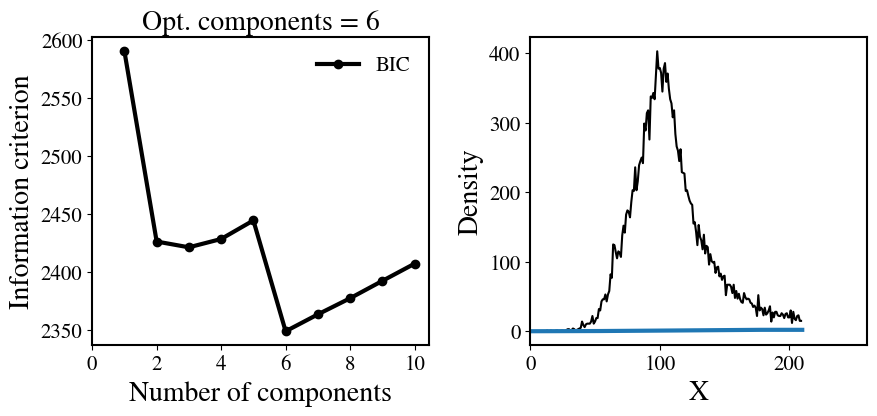

In [101]:
# import libraries (some are for cosmetics)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


# create the data 
image= cv2.imread('coins.jpg',0)
x, bins = np.histogram(image.flatten(), bins=256, range=[0,256])
x = x.reshape(-1, 1)[:210] #/ (image.shape[0] * image.shape[1])  # Normalize histogram

# first of all, let's confirm the optimal number of components
bics = []
min_bic = 0
counter=1
for i in range (10): # test the AIC/BIC metric between 1 and 10 components
  gmm = GMM(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
  labels = gmm.fit(x).predict(x)
  bic = gmm.bic(x)
  bics.append(bic)
  if bic < min_bic or min_bic == 0:
    min_bic = bic
    opt_bic = counter
  counter = counter + 1


# plot the evolution of BIC/AIC with the number of components
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,2,1)
# Plot 1
plt.plot(np.arange(1,11), bics, 'o-', lw=3, c='black', label='BIC')
plt.legend(frameon=False, fontsize=15)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Information criterion', fontsize=20)
plt.xticks(np.arange(0,11, 2))
plt.title('Opt. components = '+str(opt_bic), fontsize=20)


# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = opt_bic

# create GMM model object
print(n_optimal)
gmm = GMM(n_components = 1, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
data = image.flatten()
data = data.reshape(-1, 1)
mean = gmm.fit(data).means_  
covs  = gmm.fit(data).covariances_
weights = gmm.fit(data).weights_

# create necessary things to plot
# Adjust the range of x_axis and x_lim according to your data
x_min = np.min(x)
x_max = np.max(x)
x_axis = np.arange(0, 210, 0.1)
y_axis0 = 400*norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
# y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

ax = fig.add_subplot(1,2,2)
# Plot 2
plt.plot(x,  color='black')  # it's only one column, while x ranges from 0 to 255
plt.plot(x_axis, y_axis0, lw=3, c='C0')
# plt.plot(x_axis, y_axis1, lw=3, c='C1')
# plt.plot(x_axis, y_axis0+y_axis1, lw=3, c='C2', ls='dashed')
plt.xlim(0, 260)
#plt.ylim(0.0, 2.0)
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.subplots_adjust(wspace=0.3)
plt.show()
plt.close('all')


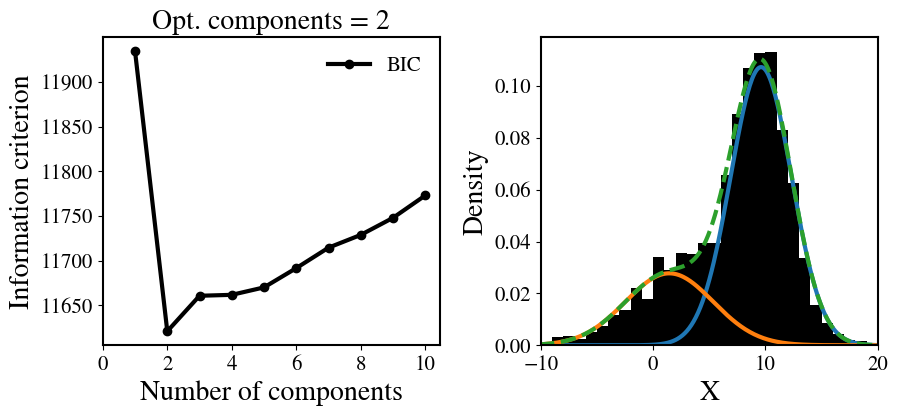

In [133]:
# import libraries (some are for cosmetics)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams.update({'font.size': 15, 'font.family': 'STIXGeneral', 'mathtext.fontset': 'stix'})


# create the data as in @Meng's answer
x = np.concatenate((np.random.normal(5, 5, 1000), np.random.normal(10, 2, 1000)))
x = x.reshape(-1, 1) # shape (2000,1)

# modify the code to plot new x
# first of all, let's confirm the optimal number of components
bics = []
min_bic = 0
counter=1
for i in range (10): # test the AIC/BIC metric between 1 and 10 components
  gmm = GMM(n_components = counter, max_iter=1000, random_state=0, covariance_type = 'full')
  labels = gmm.fit(x).predict(x)
  bic = gmm.bic(x)
  bics.append(bic)
  if bic < min_bic or min_bic == 0:
    min_bic = bic
    opt_bic = counter
  counter = counter + 1


# plot the evolution of BIC/AIC with the number of components
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(1,2,1)
# Plot 1
plt.plot(np.arange(1,11), bics, 'o-', lw=3, c='black', label='BIC')
plt.legend(frameon=False, fontsize=15)
plt.xlabel('Number of components', fontsize=20)
plt.ylabel('Information criterion', fontsize=20)
plt.xticks(np.arange(0,11, 2))
plt.title('Opt. components = '+str(opt_bic), fontsize=20)


# Since the optimal value is n=2 according to both BIC and AIC, let's write down:
n_optimal = opt_bic

# create GMM model object
gmm = GMM(n_components = n_optimal, max_iter=1000, random_state=10, covariance_type = 'full')

# find useful parameters
mean = gmm.fit(x).means_  
covs  = gmm.fit(x).covariances_
weights = gmm.fit(x).weights_

# create necessary things to plot
x_axis = np.arange(-20, 30, 0.1)
y_axis0 = norm.pdf(x_axis, float(mean[0][0]), np.sqrt(float(covs[0][0][0])))*weights[0] # 1st gaussian
y_axis1 = norm.pdf(x_axis, float(mean[1][0]), np.sqrt(float(covs[1][0][0])))*weights[1] # 2nd gaussian

ax = fig.add_subplot(1,2,2)
# Plot 2
plt.hist(x, density=True, color='black', bins=np.arange(-10, 100, 1))
plt.plot(x_axis, y_axis0, lw=3, c='C0')
plt.plot(x_axis, y_axis1, lw=3, c='C1')
plt.plot(x_axis, y_axis0+y_axis1, lw=3, c='C2', ls='dashed')
plt.xlim(-10, 20)
#plt.ylim(0.0, 2.0)
plt.xlabel(r"X", fontsize=20)
plt.ylabel(r"Density", fontsize=20)

plt.subplots_adjust(wspace=0.3)
plt.show()
plt.close('all')

            params     sigma
mu1       1.014589  0.005273
sigma1    0.203826  0.004067
A1      230.654585  3.667409
mu2       1.635225  0.022423
sigma2    0.282690  0.019070
A2       72.621856  2.148459


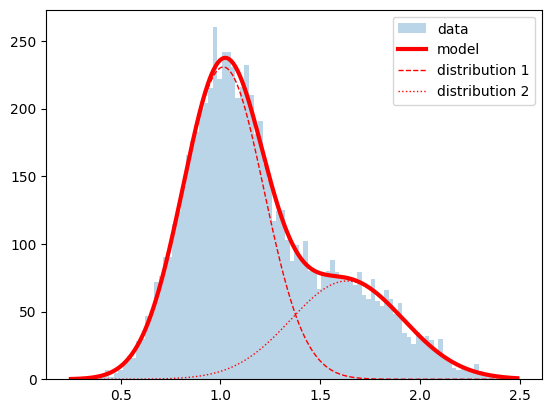

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
np.random.seed(123)
data=np.concatenate((np.random.normal(1, .2, 5000), np.random.normal(1.6, .3, 2500)))

y,x,_=plt.hist(data, 100, alpha=.3, label='data')
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-((x-mu)**2/2)/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (1, .2, 250, 2, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show()